# GA_Project4_Random Forest Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, roc_curve

%matplotlib inline


/Users/CalvinChua/Desktop/Data_Tools/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading of Data

In [2]:
# Load dataset. Let's just work with 1 file first.
# Once ok, load on everything and re-do all cells

nov17 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2017_Nov_ONTIME.csv')
dec17 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2017_Dec_ONTIME.csv')
nov16 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2016_Dec_ONTIME.csv')
dec16 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2016_Nov_ONTIME.csv')
nov15 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2015_Dec_ONTIME.csv')
dec15 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2015_Nov_ONTIME.csv')
nov14 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2014_Dec_ONTIME.csv')
dec14 = pd.read_csv(r'/Users/CalvinChua/Desktop/delay_data/2014_Nov_ONTIME.csv')

full_data = pd.concat([nov17, dec17, nov16, dec16, nov15, dec15, nov14, dec14,])

#full_data = pd.concat([nov17, dec17])


/Users/CalvinChua/Desktop/Data_Tools/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Cleaning of Data

Ensuring that data will be ready to use. 
Example: Removing null values.

Need to create a "Delayed" column to be the target.
Identify any patterns in data. (e.g. Correlation)

In [3]:
# Do a categorical 'Delayed' column by get_dummies

# Add new column to categorise delay: 1 for delay, 0 for no delay
full_data['DELAYED'] = full_data['DEP_DELAY'] >= 15
full_data.DELAYED = full_data.DELAYED.astype(int)

#full_data.head()
#full_data.groupby(['UNIQUE_CARRIER', 'DELAYED']).count()
#print(type(full_data.DELAYED))


In [4]:
#Handles class imbalance through sampling
classDistribution = full_data['DELAYED'].value_counts()
print('Class imbalance:')
print(classDistribution)


Class imbalance:
0    3063396
1     653297
Name: DELAYED, dtype: int64


This shows the large imbalance in 'DELAYED'/'NO DELAYED'.

SMOTETomek to be done later to address this imbalance.

In [5]:
# Check null

#full_data.isnull().sum()


In [6]:
# Drop the columns that are not needed
#full_data.drop(['TAXI_IN', 'TAXI_OUT', 'ORIGIN', 'DEST', 'TAXI_IN', 'TAXI_OUT', 'TAIL_NUM', 'FL_NUM',
#               'CANCELLED', 'CANCELLATION_CODE','DIVERTED', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
#                'AIR_TIME'], axis = 1, inplace = True)

# NOW TO DELETE ROWS WITH airline "FL" due to airline closure
full_data = full_data[full_data.UNIQUE_CARRIER != 'FL']

# To change "US" -> "AA" due to a merging in 2015.
full_data = full_data.replace("US", "AA")

# Drop rows that lack data for important features
total_rows = len(full_data.index)
print("There are " + str(total_rows) + ' rows.')
full_data.dropna(subset = ['UNIQUE_CARRIER', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'DEP_DELAY', 'ARR_DELAY'], inplace = True)

data_rows = len(full_data.index)
rows_retained = (data_rows/total_rows)*100
print("Percentage of data retained: " + str(rows_retained) + "%")

There are 3709802 rows.
Percentage of data retained: 98.73486509522611%


In [7]:
# Remove the rows with no value in important columns

full_data.isnull().sum()


YEAR                         0
MONTH                        0
DAY_OF_MONTH                 0
DAY_OF_WEEK                  0
UNIQUE_CARRIER               0
TAIL_NUM                     0
FL_NUM                       0
ORIGIN                       0
ORIGIN_CITY_NAME             0
DEST                         0
DEST_CITY_NAME               0
CRS_DEP_TIME                 0
DEP_TIME                     0
DEP_DELAY                    0
TAXI_OUT                     0
TAXI_IN                      0
CRS_ARR_TIME                 0
ARR_TIME                     0
ARR_DELAY                    0
CANCELLED                    0
CANCELLATION_CODE      3662868
DIVERTED                     0
CRS_ELAPSED_TIME             0
ACTUAL_ELAPSED_TIME          0
AIR_TIME                     0
DISTANCE                     0
CARRIER_DELAY          3002367
WEATHER_DELAY          3002367
NAS_DELAY              3002367
SECURITY_DELAY         3002367
LATE_AIRCRAFT_DELAY    3002367
DELAYED                      0
dtype: i

In [8]:
print(full_data.head(2))


   YEAR  MONTH  DAY_OF_MONTH  DAY_OF_WEEK UNIQUE_CARRIER TAIL_NUM  FL_NUM  \
0  2017     11            14            2             AA   N954AA    1900   
1  2017     11            15            3             AA   N949AA    1900   

  ORIGIN ORIGIN_CITY_NAME DEST   ...    CRS_ELAPSED_TIME  ACTUAL_ELAPSED_TIME  \
0    MSP  Minneapolis, MN  PHL   ...               169.0                137.0   
1    MSP  Minneapolis, MN  PHL   ...               169.0                147.0   

   AIR_TIME  DISTANCE  CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  \
0     121.0       980            NaN            NaN        NaN   
1     120.0       980            NaN            NaN        NaN   

   SECURITY_DELAY  LATE_AIRCRAFT_DELAY  DELAYED  
0             NaN                  NaN        0  
1             NaN                  NaN        0  

[2 rows x 32 columns]


# Exploratory Data Analysis

17.71797400288517 percent of flights are late.


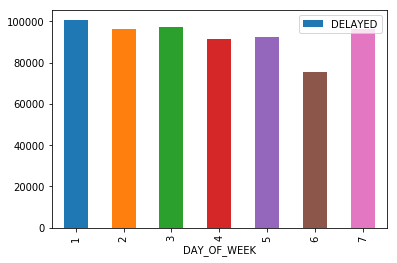

In [9]:
# Do graph of day and count

# Amt of flights
late_pct = np.sum(full_data['DELAYED'])/len(full_data['DELAYED'])*100
print(str(late_pct) + " percent of flights are late.")

# day-of-week vs % flights
#weekday = full_data.groupby(['DAY_OF_WEEK'], as_index=False).agg(np.mean)[['DAY_OF_WEEK', 'DELAYED']]
weekday = full_data.groupby(['DAY_OF_WEEK'], as_index=False).agg(np.sum)[['DAY_OF_WEEK', 'DELAYED']]

#wd = full_data.groupby('DAY_OF_WEEK')['DELAYED'].count().reset_index()
#wd['Percentage'] = 100 * wd['DELAYED']/wd['DELAYED'].sum()

#wd.sort_values(by='DAY_OF_WEEK')    
#wd.plot.bar(x='DAY_OF_WEEK', y='DELAYED')

weekday.sort_values(by='DAY_OF_WEEK')    
weekday.plot.bar(x='DAY_OF_WEEK', y='DELAYED')


In [10]:
# Could the above graph be due to more flights?

day_week = full_data[['DAY_OF_WEEK', 'DELAYED', 'UNIQUE_CARRIER']]
print(day_week.groupby('DAY_OF_WEEK').count())


             DELAYED  UNIQUE_CARRIER
DAY_OF_WEEK                         
1             530930          530930
2             539437          539437
3             560325          560325
4             525279          525279
5             525458          525458
6             457347          457347
7             524092          524092


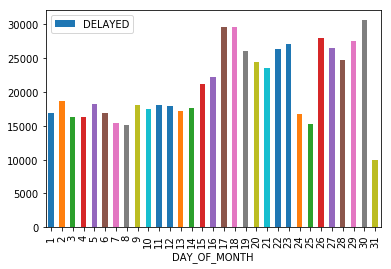

In [11]:
# Do graph of day_month and count

# Amt of flights
#late_per = np.sum(full_data['DELAYED'])/len(full_data['DELAYED'])*100
#print(str(late_per) + " percent of flights are late.")

# day-of-month vs % flights
#month_day = full_data.groupby(['DAY_OF_MONTH'], as_index=False).aggregate(np.mean)[['DAY_OF_MONTH', 'DELAYED']]
month_day = full_data.groupby(['DAY_OF_MONTH'], as_index=False).aggregate(np.sum)[['DAY_OF_MONTH', 'DELAYED']]
month_day.sort_values(by='DAY_OF_MONTH', inplace=True)    
month_day.plot.bar(x='DAY_OF_MONTH', y='DELAYED')


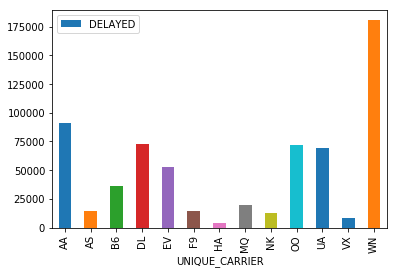

In [12]:
# carrier vs % flights
#carrier = full_data.groupby(['UNIQUE_CARRIER'], as_index=False).aggregate(np.mean)[['UNIQUE_CARRIER', 'DELAYED']]
carrier = full_data.groupby(['UNIQUE_CARRIER'], as_index=False).aggregate(np.sum)[['UNIQUE_CARRIER', 'DELAYED']]
carrier.sort_values(by='UNIQUE_CARRIER', inplace=True)
carrier.plot.bar(x='UNIQUE_CARRIER', y='DELAYED')


In [13]:
# Maybe origin causes the delays?

# origin vs % flights
#origin_city = full_data.groupby(['ORIGIN'], as_index=False).aggregate(np.mean)[['ORIGIN', 'DELAYED']]
#origin_city.sort_values(by='ORIGIN')    
#origin_city.plot.bar(x='ORIGIN', y='DELAYED')
#print(origin_city.sort_values(by='DELAYED', ascending= False))
#print(origin_city)


# Perform Label Encoding

This is to enable all columns to be used for learning.
Positive: Save 1,000,000 columns compared to 'get_dummies'

In [14]:
# Can we label encode Origin and Arrive?
le = LabelEncoder()

# Encode Origin
#le.fit(full_data['ORIGIN_CITY_NAME'])
#list(le.classes_)
#le.transform(full_data['ORIGIN_CITY_NAME'])
full_data['ORIGIN_CITY_NAME'] = le.fit_transform(full_data['ORIGIN_CITY_NAME'])
ORIGIN_CITY_NAME = list(le.classes_)

# Encode DEST
#le.fit(full_data['DEST_CITY_NAME'])
#list(le.classes_)
#le.transform(full_data['DEST_CITY_NAME'])
full_data['DEST_CITY_NAME'] = le.fit_transform(full_data['DEST_CITY_NAME'])
DEST_CITY_NAME = list(le.classes_)

# Encode CARRIER
#le.fit(full_data['UNIQUE_CARRIER'])
#list(le.classes_)
#le.transform(full_data['UNIQUE_CARRIER'])
full_data['UNIQUE_CARRIER'] = le.fit_transform(full_data['UNIQUE_CARRIER'])
UNIQUE_CARRIER = list(le.classes_)

#print(full_data.head())


In [15]:
full_data.describe()


,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN_CITY_NAME,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DELAYED
count,3.662868e+06,3.662868e+06,3.662868e+06,3.662868e+06,3.662868e+06,3.662868e+06,3.662868e+06,3.662868e+06,3.662868e+06,3.662868e+06,...,3.662868e+06,3.662868e+06,3.662868e+06,3.662868e+06,660501.000000,660501.000000,660501.000000,660501.000000,660501.000000,3.662868e+06
mean,2.015492e+03,1.150406e+01,1.570076e+01,3.940058e+00,6.244417e+00,2.208467e+03,1.550595e+02,1.552595e+02,1.327587e+03,1.332871e+03,...,1.449594e+02,1.394238e+02,1.157619e+02,8.382864e+02,19.106622,2.509889,13.507224,0.108294,23.461839,1.771797e-01
std,1.117567e+00,4.999836e-01,8.795784e+00,1.993402e+00,4.492391e+00,1.789935e+03,9.093493e+01,9.092320e+01,4.847227e+02,4.959906e+02,...,7.649360e+01,7.549379e+01,7.350795e+01,6.130131e+02,54.511521,23.414858,29.127732,3.225492,44.255467,3.818208e-01
min,2.014000e+03,1.100000e+01,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,...,2.100000e+01,1.400000e+01,7.000000e+00,3.100000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2.014000e+03,1.100000e+01,8.000000e+00,2.000000e+00,3.000000e+00,7.360000e+02,7.500000e+01,7.500000e+01,9.170000e+02,9.210000e+02,...,8.800000e+01,8.400000e+01,6.100000e+01,3.860000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2.015000e+03,1.200000e+01,1.600000e+01,4.000000e+00,6.000000e+00,1.722000e+03,1.690000e+02,1.700000e+02,1.320000e+03,1.328000e+03,...,1.250000e+02,1.210000e+02,9.700000e+01,6.720000e+02,2.000000,0.000000,2.000000,0.000000,4.000000,0.000000e+00
75%,2.016000e+03,1.200000e+01,2.300000e+01,6.000000e+00,1.000000e+01,3.232000e+03,2.350000e+02,2.350000e+02,1.730000e+03,1.738000e+03,...,1.770000e+02,1.710000e+02,1.460000e+02,1.075000e+03,18.000000,0.000000,18.000000,0.000000,29.000000,0.000000e+00
max,2.017000e+03,1.200000e+01,3.100000e+01,7.000000e+00,1.200000e+01,9.320000e+03,3.200000e+02,3.200000e+02,2.359000e+03,2.400000e+03,...,7.180000e+02,7.780000e+02,7.230000e+02,4.983000e+03,2402.000000,1587.000000,1605.000000,827.000000,1756.000000,1.000000e+00


In [16]:
print(full_data.head(2))


   YEAR  MONTH  DAY_OF_MONTH  DAY_OF_WEEK  UNIQUE_CARRIER TAIL_NUM  FL_NUM  \
0  2017     11            14            2               0   N954AA    1900   
1  2017     11            15            3               0   N949AA    1900   

  ORIGIN  ORIGIN_CITY_NAME DEST   ...     CRS_ELAPSED_TIME  \
0    MSP               195  PHL   ...                169.0   
1    MSP               195  PHL   ...                169.0   

   ACTUAL_ELAPSED_TIME  AIR_TIME  DISTANCE  CARRIER_DELAY  WEATHER_DELAY  \
0                137.0     121.0       980            NaN            NaN   
1                147.0     120.0       980            NaN            NaN   

   NAS_DELAY  SECURITY_DELAY  LATE_AIRCRAFT_DELAY  DELAYED  
0        NaN             NaN                  NaN        0  
1        NaN             NaN                  NaN        0  

[2 rows x 32 columns]


In [17]:
# to transform back encoded values -------

# list(le.inverse_transform([2, 2, 1]))
# ['tokyo', 'tokyo', 'paris']


In [18]:
# Check corr

#features = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER',
#            'ORIGIN_CITY_NAME','DEST_CITY_NAME',
#            'DEP_TIME', 'DEP_DELAY', 'ARR_TIME',
#            'ARR_DELAY', 'DISTANCE','CARRIER_DELAY', 'WEATHER_DELAY',
#            'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

#feat = pd.DataFrame(full_data, columns=features)
#target = pd.DataFrame(full_data, columns=['DELAYED'])
#df = feat.join(target)
#f,ax=plt.subplots(figsize=(15,15))
#sns.heatmap(df.corr(), cmap = 'coolwarm', annot=True, ax=ax, linewidth=.5)

full_data.corr()


,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN_CITY_NAME,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DELAYED
YEAR,1.000000,-0.003235,0.007022,0.016411,0.035204,-0.004716,0.011411,0.011237,0.004918,0.000464,...,0.047218,0.034156,0.030289,0.033110,0.027778,0.020421,0.010252,0.013481,0.007088,-0.041734
MONTH,-0.003235,1.000000,0.031180,-0.006977,-0.000179,0.007253,0.004464,0.004442,0.000219,0.004379,...,0.022525,0.029064,0.023170,0.017233,0.006255,0.018746,-0.000236,-0.005365,0.038532,0.087990
DAY_OF_MONTH,0.007022,0.031180,1.000000,0.019957,0.001211,0.038653,0.004566,0.004538,0.000947,0.003961,...,0.026178,0.027759,0.025923,0.024210,0.008948,0.005022,-0.031706,-0.001348,0.040840,0.076941
DAY_OF_WEEK,0.016411,-0.006977,0.019957,1.000000,-0.005194,0.021418,0.003921,0.003513,0.009019,0.006628,...,0.014847,0.013625,0.014276,0.016367,0.016614,0.014772,0.001435,0.001345,0.006927,-0.007209
UNIQUE_CARRIER,0.035204,-0.000179,0.001211,-0.005194,1.000000,0.219665,0.049311,0.049685,0.006839,0.015190,...,-0.128239,-0.135292,-0.110590,-0.106048,-0.033477,-0.007236,-0.061543,-0.005549,0.057051,0.064761
FL_NUM,-0.004716,0.007253,0.038653,0.021418,0.219665,1.000000,-0.038949,-0.039465,-0.001695,0.005624,...,-0.295822,-0.288703,-0.299945,-0.310851,0.018474,0.008059,-0.013935,-0.004533,0.047096,0.019160
ORIGIN_CITY_NAME,0.011411,0.004464,0.004566,0.003921,0.049311,-0.038949,1.000000,-0.010407,-0.049158,-0.049834,...,0.102698,0.102882,0.101844,0.115644,-0.017640,-0.031134,0.002767,0.004374,0.040930,0.000041
DEST_CITY_NAME,0.011237,0.004442,0.004538,0.003513,0.049685,-0.039465,-0.010407,1.000000,0.057917,0.057665,...,0.111052,0.116001,0.126086,0.114962,-0.023323,-0.011235,0.034542,0.001572,-0.025978,0.027089
CRS_DEP_TIME,0.004918,0.000219,0.000947,0.009019,0.006839,-0.001695,-0.049158,0.057917,1.000000,0.964490,...,-0.022228,-0.024920,-0.017333,-0.009460,-0.067088,-0.028823,-0.090778,-0.002815,0.140644,0.149211
DEP_TIME,0.000464,0.004379,0.003961,0.006628,0.015190,0.005624,-0.049834,0.057665,0.964490,1.000000,...,-0.027822,-0.029564,-0.023055,-0.017750,-0.028068,-0.026108,-0.069689,-0.000491,0.192318,0.199149


From the correlation matrix, we can see the following: Look at the 5 highest
1) Depature Delay: Correlated with 'UNIQUE_CARRIER', & 'LATE_AIRCRAFT_DELAY'
2) Depature delay & carrier are related

Following this, we shall proceed to remove columns with too much collinearity.

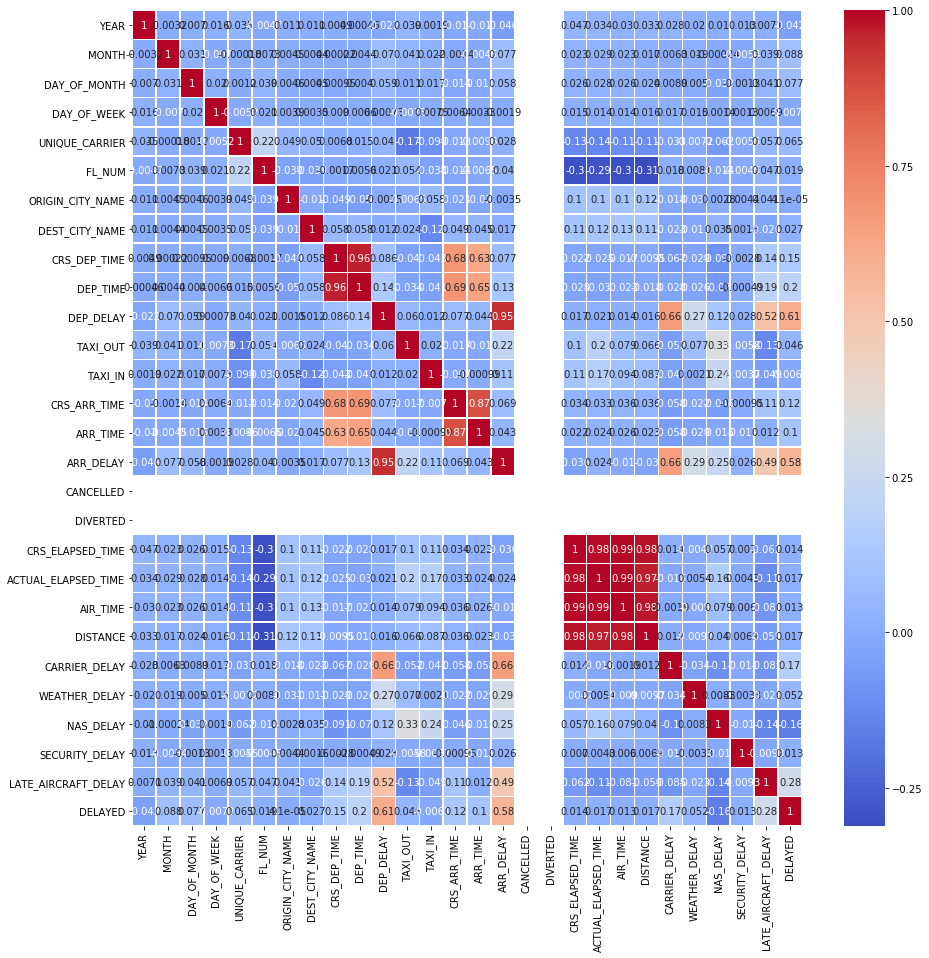

In [19]:
# Check collinearity of features

#features = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER',
#            'ORIGIN_CITY_NAME','DEST_CITY_NAME',
#            'DEP_TIME', 'DEP_DELAY', 'ARR_TIME',
#            'ARR_DELAY', 'DISTANCE','CARRIER_DELAY', 'WEATHER_DELAY',
#            'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

#feat = pd.DataFrame(full_data, columns=features)
#target = pd.DataFrame(full_data, columns=['DELAYED'])
#df = feat.join(target)
f,ax=plt.subplots(figsize=(15,15))
sns.heatmap(full_data.corr(), cmap = 'coolwarm', annot=True, ax=ax, linewidth=.5)


In [20]:
#Drop the columns that are not needed
full_data.drop(['TAXI_IN', 'TAXI_OUT', 'ORIGIN', 'DEST', 'TAXI_IN', 'TAXI_OUT', 'TAIL_NUM',
               'CANCELLED', 'CANCELLATION_CODE','DIVERTED', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
                'AIR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME'], axis = 1, inplace = True)

#print(full_data.head(2))


In [21]:
# Which are the most popular airports??
# Taking the top 10 most popular origins. Assume that they are the most popular destinations.
# Origins are: ATL (17), ORD(60), DFW(78), DEN(82), LAX(179), SFO(137), PHX(212), IAH(264), LAS(235), MCO(169)
origin_count = full_data.groupby('ORIGIN_CITY_NAME').count()
origin_count = origin_count.sort_values(by = 'FL_NUM', ascending = False)
print(origin_count)


                    YEAR   MONTH  DAY_OF_MONTH  DAY_OF_WEEK  UNIQUE_CARRIER  \
ORIGIN_CITY_NAME                                                              
17                233747  233747        233747       233747          233747   
60                229311  229311        229311       229311          229311   
78                142526  142526        142526       142526          142526   
82                139898  139898        139898       139898          139898   
179               136717  136717        136717       136717          136717   
137               131966  131966        131966       131966          131966   
212               125736  125736        125736       125736          125736   
264               109476  109476        109476       109476          109476   
235               102161  102161        102161       102161          102161   
169                93047   93047         93047        93047           93047   
224                81612   81612         81612      

In [43]:
#correlate = full_data.corr()
#indices = np.where(correlate > 0.8)
#indices = [(correlate.columns[x], correlate.columns[y]) for x, y in zip(*indices)
#                                        if x != y and x < y]
#indices


# SMOTETomek due to Class Imbalance 

In [23]:
# SMOTETomek-ing

#from collections import Counter
#from sklearn.datasets import make_classification
#from imblearn.combine import SMOTETomek 

smt = SMOTETomek(random_state=242)

features = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'UNIQUE_CARRIER', 'ORIGIN_CITY_NAME',
            'DEST_CITY_NAME', 'DEP_TIME', 'ARR_TIME', 'DISTANCE']

X = full_data[features]
y = full_data['DELAYED']

X_res, y_res = smt.fit_sample(X, y)

print('Original ''y'' dataset shape {}'.format(Counter(y)))
print('Resampled ''y'' dataset shape {}'.format(Counter(y_res)))

X_samp = pd.DataFrame(X_res, columns = features)
y_samp = pd.DataFrame(y_res, columns = ['DELAYED'])


Original y dataset shape Counter({0: 3013882, 1: 648986})
Resampled y dataset shape Counter({0: 2954679, 1: 2954679})


# Start Learning!

3 choices as recommended: Decision Trees, Random Forest Regression, Logistic Regression
Why?
Decision Trees: Work well for both regression and classification tasks. 
Random Forest Regression: Can be used both for classification and regression.
Logistic Regression: Useful method for predicting binary classes ('1' or '0'), to compute the probability of an event occurrence.

In [24]:
#X_train, X_test, Y_train, Y_test = train_test_split(rfDataOriginal, Delay_YesNo, test_size=0.2, random_state=42)
#data_model1 = full_data

X_samp_train, X_samp_test, y_samp_train, y_samp_test = train_test_split(X_samp,
                                                                        y_samp, test_size=0.5, random_state=42)


In [25]:
from sklearn.preprocessing import StandardScaler

X_samp = StandardScaler()
X_samp_train = X_samp.fit_transform(X_samp_train)
X_samp_test = X_samp.transform(X_samp_test)


# Random Forest Classifier

How do we tune a Random Forest Classifier model?

By adjust the variables in the code. One way to find the optimal is by using "GridSearchCV".
Not sure if it works as it takes too long to process.

By using the default RANDOMFORESTCLASSIFIER, accuracy score: 90% and recall of 85%.



In [26]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
rf = RandomForestClassifier()
#param_grid = {
#                 'n_estimators': [10, 25],
#                 'min_samples_split': [2, 4],
#                 'min_samples_leaf': [2, 4],
#                 'max_features': ['sqrt', 'log2'],
#                 "criterion" : ["gini", "entropy"]
#             }
#grid_rf = GridSearchCV(rf, param_grid, cv=10)
#grid_rf.fit(X_train, y_train)
#bestModel = grid_rf.best_estimator_
#bestParameters = grid_rf.best_params_
#gridScores = grid_rf.grid_scores_

/Users/CalvinChua/Desktop/Data_Tools/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [27]:
#print(bestModel)
#print(bestParameters)
#gridScores


In [28]:
#rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
#            max_depth=None, max_features='auto', max_leaf_nodes=None,
#            min_impurity_split=1e-07, min_samples_leaf=1,
#            min_samples_split=2, min_weight_fraction_leaf=0.0,
#            n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
#            verbose=0, warm_start=False)

rf = RandomForestClassifier()
rf.fit(X_samp_train, y_samp_train)
#bestModel = grid_rf.best_estimator_
#bestParameters = grid_rf.best_params_
#gridScores = grid_rf.grid_scores_


/Users/CalvinChua/Desktop/Data_Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
cv = cross_validation.KFold(len(X_samp_train), n_folds=10, shuffle=True, random_state=5)
#print(cv)
#cvScores = cross_val_score(rf, X_train, y_train, cv=cv)
#print ('Mean cross validation score is: ' + str(np.mean(cvScores)))


In [30]:
cvScores = cross_val_score(rf, X_samp_train, y_samp_train, cv=cv)
print ('Mean cross validation score is: ' + str(np.mean(cvScores)))


/Users/CalvinChua/Desktop/Data_Tools/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/CalvinChua/Desktop/Data_Tools/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/CalvinChua/Desktop/Data_Tools/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/CalvinChua/Desktop/Data_Too

Mean cross validation score is: 0.9045595137822685


In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [32]:
trained_model = rf.fit(X_samp_train, y_samp_train)
print ("Trained model :: ", trained_model)
prediction = trained_model.predict(X_samp_test)


/Users/CalvinChua/Desktop/Data_Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


Trained model ::  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [35]:
print ("Train Accuracy :: ", accuracy_score(y_samp_train, trained_model.predict(X_samp_train)))
print ("Test Accuracy  :: ", accuracy_score(y_samp_test, prediction))


Train Accuracy ::  0.9932364903260219
Test Accuracy  ::  0.90743698384833


In [36]:
y_rf_pred = rf.predict(X_samp_test)

labels = [0, 1]
cm = confusion_matrix(y_samp_test, y_rf_pred,labels)

print('Accuracy: ' + str(np.round(100*float(cm[0][0]+cm[1][1])/float((cm[0][0]+cm[1][1] + cm[1][0] + cm[0][1])),2))+'%')
print('Recall: ' + str(np.round(100*float((cm[1][1]))/float((cm[1][0]+cm[1][1])),2))+'%')
print('Confusion matrix:')
print(cm)

#fpr, tpr, _ = roc_curve(y_test, y_rf_pred)
#auc = np.trapz(fpr,tpr)
#print('Area under the ROC curve: ' + str(auc))

#fig = plt.figure(1)
#plt.plot(fpr,tpr,color='green')
#plt.xlabel('False positive rate (FPR)')
#plt.ylabel('True positive rate (TPR)')
#plt.title('Receiver operating characteristic (ROC)')

#fig = plt.figure(2)
#ax = fig.add_subplot(111)
#cax = ax.matshow(cm)
#plt.title('Confusion matrix for Random Forest classifier with original data')
#fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.show()


Accuracy: 90.74%
Recall: 85.01%
Confusion matrix:
[[1426146   52108]
 [ 221386 1255039]]


Area under the ROC curve: 0.09259851611531306


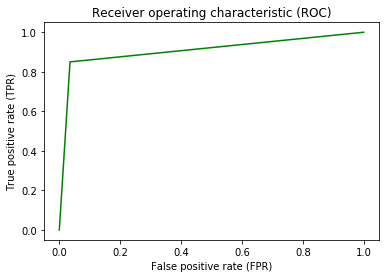

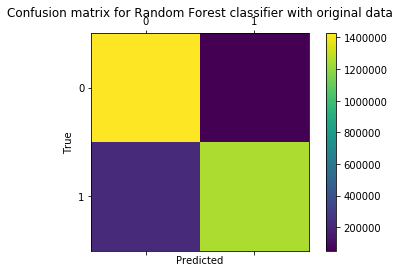

In [38]:
fpr, tpr, _ = roc_curve(y_samp_test, y_rf_pred)
auc = np.trapz(fpr,tpr)
print('Area under the ROC curve: ' + str(auc))

fig = plt.figure(1)
plt.plot(fpr,tpr,color='green')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('Receiver operating characteristic (ROC)')

fig = plt.figure(2)
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for Random Forest classifier with original data')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


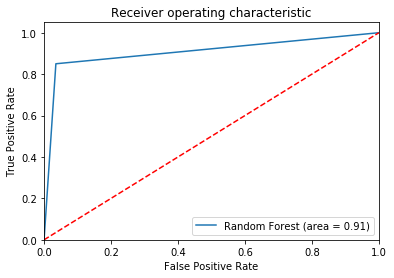

In [40]:
from sklearn.metrics import roc_auc_score

logit_roc_auc = roc_auc_score(y_samp_test, y_rf_pred)
fpr, tpr, thresholds = roc_curve(y_samp_test, y_rf_pred)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_samp_test, y_rf_pred))

             precision    recall  f1-score   support

          0       0.87      0.96      0.91   1478254
          1       0.96      0.85      0.90   1476425

avg / total       0.91      0.91      0.91   2954679



# Logistic Regression

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

In [ ]:
#import statsmodels.formula.api as sm
#logit_model=sm.Logit(y,X)
#result=logit_model.fit()
#print(result.summary2())

#Remove those columns that p-value is more than 0.05
#Then re-do the code again to check

#logit_model=sm.Logit(y,X)
#result=logit_model.fit()
#print(result.summary2())

In [ ]:
#logreg = LogisticRegression(C=5)
#logreg.fit(X_samp_train, y_samp_train)

In [ ]:
#y_samp_pred = logreg.predict(X_samp_test)

#Check accuracy
#y_pred = logreg.predict(X_test)
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
#trained_model = logreg.fit(X_samp_train, y_samp_train)
#print ("Trained model :: ", trained_model)
#prediction = trained_model.predict(X_samp_test)

#for i in range(0, 10):
#    print ("Actual outcome :: {} and Predicted outcome :: {}".format(list(y_samp_test)[i], prediction[i]))
#    i = i + 1

In [ ]:
#confusion_matrix = confusion_matrix(y_samp_test, y_samp_pred)
#print(confusion_matrix)

In [ ]:
#from sklearn.metrics import classification_report
#print(classification_report(y_samp_test, y_samp_pred))

In [ ]:
#from sklearn.metrics import roc_auc_score

#logit_roc_auc = roc_auc_score(y_samp_test, logreg.predict(X_samp_test))
#fpr, tpr, thresholds = roc_curve(y_samp_test, logreg.predict_proba(X_samp_test)[:,1])
#plt.figure()
#plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic')
#plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
#plt.show()

# Decision Tree

In [ ]:
#from sklearn import tree
#import graphviz 

#clf = tree.DecisionTreeClassifier()
#clf = clf.fit(X_train, y_train)


In [ ]:
#dot_data = tree.export_graphviz(clf, out_file=None)
#graph = graphviz.Source(dot_data)
#graph
